<div style="display:flex; gap:20px;">
  <div style="background-color:'#1E1E1E'; padding:10px;">
    <img src="https://github.com/pocolpaolo10tue/atai-2025-assignment-2/blob/main/practicals/CFD/output/visuals_Re200.gif?raw=1" width="600">
  </div>
  <div style="background-color:'#1E1E1E'; padding:10px;">
    <img src="https://github.com/pocolpaolo10tue/atai-2025-assignment-2/blob/main/practicals/CFD/output/visuals_Re400.gif?raw=1" width="600">
  </div>
</div>

In [1]:
# Clone and cd so relative paths match the repo layout
REPO_URL = "https://github.com/pocolpaolo10tue/atai-2025.git"
REPO_DIR = "atai-2025"
NB_SUBDIR = "practicals/CFD"   # folder that contains this notebook

from pathlib import Path
import os, sys
repo_path = Path("/content")/REPO_DIR
subdir_path = repo_path/NB_SUBDIR

if not repo_path.exists():
    !git clone --depth 1 --branch main {REPO_URL} {repo_path}

assert subdir_path.exists(), f"Missing: {subdir_path}"
%cd {subdir_path}
print("CWD:", os.getcwd())

Cloning into '/content/atai-2025'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 93 (delta 0), reused 90 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (93/93), 1.79 GiB | 49.13 MiB/s, done.
Updating files: 100% (76/76), done.
/content/atai-2025/practicals/CFD
CWD: /content/atai-2025/practicals/CFD


### Import core libraries
We start by importing PyTorch and other essential libraries.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from torch.optim.lr_scheduler import ReduceLROnPlateau

# for cleaner look (set your theme to dark mode)
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#1E1E1E'
plt.rcParams['axes.facecolor'] = '#1E1E1E'
plt.rcParams['savefig.facecolor'] = '#1E1E1E'

from tqdm import tqdm
from IPython.display import Image

In [3]:
################# quickfix for Snellius GPU MIG usage
import os
import subprocess
if "MIG" in subprocess.check_output(["nvidia-smi", "-L"], text=True):
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Check CUDA availability
Here we check if a GPU is available for faster training. GPU usage is highly recommended.

In [4]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device name: {torch.cuda.get_device_name()}")

CUDA available: True
CUDA device name: NVIDIA A100-SXM4-40GB


### Data preparation step
Fuse the raw data files so they can be read by the dataset object.

In [5]:
# this box fuses the loose data files such that they can be read by the dataset object
base_in = '../../data/CFD/grid/loose/'
base_out2 = '../../data/CFD/grid/concat/'
os.makedirs(base_out2, exist_ok=True)
for Re in [100,150,200,250,300,350,400]:
    u = np.load(f"{base_in}u_grid_Re{Re}.npy")
    v = np.load(f"{base_in}v_grid_Re{Re}.npy")
    p = np.load(f"{base_in}p_grid_Re{Re}.npy")
    concat = np.stack([u, v, p], axis=1)
    filename_save = f"{base_out2}uvp_grid_Re{Re}.npy"
    np.save(filename_save, concat)

## Dataset object for standard ARM model

### Model input and output
- **Input**: fluid field information (e.g., velocity and pressure at the current timestep, possibly with coordinates/masks).  
- **Output**: predicted velocity and pressure fields at the **next timestep**.  
This setup makes the model autoregressive: predictions from one step are fed as input to predict the next.

### Define Dataset class
This class handles how fluid data is loaded and accessed. The dataset consists of 7 different trajectories of flow passing a cilindrical obstacle, each with their own Reynolds number. For the training data we use $Re$=[100,200,300,400] and for validation we use zero-shot validation on $Re$=[150,250,350]. The data consists of the $V_x$, $V_y$ and $p$ fields in 2 spatial dimensions and time. At the top of the notebook two example trajectories can be seen. The dataset object also supplies an obstacle mask, the coordinates and the option to flip-augment the data. Only the boolean obstacle mask will be used.

In [6]:
class FlowDataset(Dataset):
    def __init__(self, filenames, flip_augmentation=False, timesample=1):
        self.sequences = []
        self.index_map = []
        self.flip_augmentation = flip_augmentation

        # coordinates
        self.coordsy = np.linspace(-5, 5, 64, endpoint=True)
        self.coordsx = np.linspace(-10, 10, 128, endpoint=True)
        self.coords = np.array(np.meshgrid(self.coordsx, self.coordsy)).T.reshape(128, 64, 2)
        self.coords = torch.tensor(self.coords, dtype=torch.float32).permute(2, 1, 0).cuda()

        # use coordinates to make obstacle mask
        center = torch.tensor([-5.0, 0.0], device=self.coords.device).view(2, 1, 1)
        radius = 0.5
        squared_distance = ((self.coords - center) ** 2).sum(dim=0)
        self.mask = squared_distance < radius**2  # shape [64, 128]
        self.mask = self.mask.unsqueeze(0).cuda()

        # sample/read the data
        for seq_idx, filename in enumerate(filenames):
            data = np.load(filename)
            data = data[::timesample]
            self.sequences.append(data)
            T = data.shape[0]
            self.index_map.extend([(seq_idx, t) for t in range(T - 1)])

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        seq_idx, t = self.index_map[idx]
        seq = self.sequences[seq_idx]
        input = seq[t]
        target = seq[t + 1]

        # if flip augmentation is true then flip the data horizontally 50% of the time
        if self.flip_augmentation and np.random.rand() > 0.5:
            input = self.flip(input)
            target = self.flip(target)
        return (
                self.mask,
                self.coords,
                torch.tensor(input, dtype=torch.float32),
                torch.tensor(target, dtype=torch.float32)
                )

    def get_trajectory(self, seq_idx):
        # returns full trajectory
        seq = self.sequences[seq_idx]
        return (
            self.mask.unsqueeze(0),
            self.coords.unsqueeze(0),
            torch.tensor(seq, dtype=torch.float32)
        )

    def flip(self, x):
        x = np.flip(x, axis=2).copy()
        x[1] *= -1
        return x

datafolder = '../../data/CFD/grid/concat/'
train_files = [
    'uvp_grid_Re100.npy',
    'uvp_grid_Re200.npy',
    'uvp_grid_Re300.npy',
    'uvp_grid_Re400.npy'
]
val_files = [
    'uvp_grid_Re150.npy',
    'uvp_grid_Re250.npy',
    'uvp_grid_Re350.npy'
]
train_files = [datafolder + f for f in train_files]
val_files = [datafolder + f for f in val_files]

dt = 20 # only sample every dt timesteps
batch_size = 64
train_dataset = FlowDataset(train_files, flip_augmentation=False, timesample=dt)
val_dataset = FlowDataset(val_files, flip_augmentation=False, timesample=dt)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Model

### Define Model architecture
Here we build the building blocks of the autoregressive model.

### U-Net architecture (overview)
The model is based on a **U-Net**, which is a type of encoder–decoder neural network with skip connections.
- **Encoder**: progressively downsamples the input, extracting features at multiple scales.
- **Decoder**: upsamples the features back to the original resolution.
- **Skip connections**: link encoder and decoder layers at the same scale, helping the model preserve spatial details.

Below is a generic diagram of U-Net (not exactly your model, but the same idea):



In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropprob=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Dropout2d(p=dropprob)
        )

    def forward(self, x):
        return self.net(x)

class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels=64,mult=[1, 2, 4, 8]):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(in_channels, base_channels * mult[0])
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(base_channels * mult[0], base_channels * mult[1])
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(base_channels * mult[1], base_channels * mult[2])
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(base_channels * mult[2], base_channels * mult[3])

        # Decoder
        self.up3 = nn.ConvTranspose2d(base_channels * mult[3], base_channels * mult[2], kernel_size=2, stride=2)
        self.dec3 = DoubleConv(2 *base_channels * mult[2], base_channels * mult[2])
        self.up2 = nn.ConvTranspose2d(base_channels * mult[2], base_channels * mult[1], kernel_size=2, stride=2)
        self.dec2 = DoubleConv(2 * base_channels * mult[1], base_channels * mult[1])
        self.up1 = nn.ConvTranspose2d(base_channels * mult[1], base_channels * mult[0], kernel_size=2, stride=2)
        self.dec1 = DoubleConv(2 * base_channels * mult[0], base_channels * mult[0])

        self.out_conv = nn.Conv2d(base_channels * mult[0], out_channels, kernel_size=1)

    def forward(self, x):

        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))

        x4 = self.bottleneck(self.pool3(x3))

        x = self.up3(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.dec3(x)
        x = self.up2(x3)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)

        return self.out_conv(x)

def _amount_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [8]:
base_channels = 64
use_coords = False
use_geometry = True
in_channels = 3
if use_coords:
    in_channels += 2
if use_geometry:
    in_channels += 1

epochs = 400
init_lr = 0.001
factor = 0.1
patience = 20
min_lr = 1e-7

train_mode = False # determines whether the model will be trained or loaded from file
save_mode = False # if train_mode is True, then saves the model is save_mode is True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet(in_channels=in_channels, out_channels=3, base_channels=base_channels, mult=[1, 2, 2, 2]).to(device)
print(f"Amount of parameters in model: {_amount_params(model)}, will use {in_channels} input channels")
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=init_lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, min_lr=min_lr)

Amount of parameters in model: 2014467, will use 4 input channels


In [9]:
def _input_fuse(mask, coords, input, use_coords, use_geometry):
    # this function fuses the input channels, obstacle mask coordinates and the velocity and pressure data
    if use_coords and use_geometry:
        input = torch.cat([mask, coords, input], dim=1)
    elif use_coords and not use_geometry:
        input = torch.cat([coords, input], dim=1)
    elif not use_coords and use_geometry:
        input = torch.cat([mask, input], dim=1)
    return input

### Training function
Define how the model will be trained (loop, loss, optimizer, etc.). Currently we load the model from memory instead of training.

In [10]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):

    for epoch in range(epochs):
        train_losses = []
        val_loss = []

        model.train()
        train_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", leave=False) # for cleaner look during training
        for mask, coords, input, target in train_bar:
            mask, coords, input, target = mask.to(device), coords.to(device), input.to(device), target.to(device)
            optimizer.zero_grad()
            input = _input_fuse(mask, coords, input, use_coords, use_geometry) #concat input channels
            output = model(input)
            train_loss = criterion(output, target)
            train_loss.backward()
            optimizer.step()
            train_losses.append(train_loss.item())
            train_bar.set_postfix(loss=f"{train_loss.item():.6f}")

        model.eval()
        val_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}", leave=False)
        with torch.no_grad():
            for mask, coords, input, target in val_bar:
                mask, coords, input, target = mask.to(device), coords.to(device), input.to(device), target.to(device)
                input = _input_fuse(mask, coords, input, use_coords, use_geometry)
                output = model(input)
                loss = criterion(output, target).item()
                val_loss.append(loss)
                val_bar.set_postfix(loss=f"{loss:.6f}")

        if epoch % 10 == 0 or epoch == epochs - 1: # plot every 10 epochs and also at the last epoch
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Train Loss: {np.mean(train_losses):.6f}, Val Loss: {np.mean(val_loss):.6f}, LR: {optimizer.param_groups[0]['lr']:.8f}")
        scheduler.step(np.mean(val_loss))


if train_mode == True:
    print("Training mode enabled, starting training...")
    train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)
    if save_mode:
        save_model(model, '../../models/CFD/model1.pth')
else:
    print("Loading model from file...")
    model.load_state_dict(torch.load('../../models/CFD/model1.pth'))

torch.cuda.empty_cache() # clear cache for memory management

Loading model from file...


### Rollout method
A **rollout** means running the trained model forward in time for many steps, using its predictions as inputs for the next steps.  
This is how we evaluate the model’s ability to simulate fluid dynamics beyond a single timestep.

The following block also contains helper functions for creating animations and plotting comparisons...

In [11]:
# helper functions

def rollout(model, mask, coords, init_frame, use_coords, use_geometry, length=100):
    # this function does a rollout of the ARM
    model.eval()
    with torch.no_grad():
        input = _input_fuse(mask, coords, init_frame, use_coords, use_geometry)
        output_sequence = []
        output_sequence.append(init_frame.squeeze(0).cpu())

        for _ in range(length):
            output = model(input)
            output_sequence.append(output.squeeze(0).cpu())
            input = _input_fuse(mask, coords, output, use_coords, use_geometry)

    return torch.stack(output_sequence)

def magnitude(tensor):
    # calculates the radial componentn/magnitude of the 2D velocity field
    return torch.sqrt(tensor[:,0,:,:]**2 + tensor[:,1,:,:]**2)

def animate_rollout(stacked_pred_vel, stacked_true_vel, stacked_pred_p, stacked_true_p, output_path="output/rollout.gif"):
    # this function makes the animation file, given the predicted and true velocity and pressure fields
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    timesteps, x_dim, y_dim = stacked_pred_vel.shape
    if timesteps > stacked_true_vel.shape[0]:
        timesteps = stacked_true_vel.shape[0]
    stacked_pred_vel, stacked_true_vel = stacked_pred_vel.squeeze(1).cpu().numpy(), stacked_true_vel.squeeze(1).cpu().numpy()
    stacked_pred_p, stacked_true_p = stacked_pred_p.squeeze(1).cpu().numpy(), stacked_true_p.squeeze(1).cpu().numpy()
    vmax_vel = min(np.max(stacked_pred_vel), np.max(stacked_true_vel))
    vmax_p = min(np.max(stacked_pred_p), np.max(stacked_true_p))
    fig, axes = plt.subplots(2, 3, figsize=(15, 5))
    titles = ["Pred", "True", "Diff"]
    imgs = []

    for i in range(2):
        row_imgs = []
        for j in range(3):
            ax = axes[i, j]
            img = ax.imshow(np.zeros((x_dim, y_dim)), cmap='viridis', vmin=0, vmax=vmax_vel if i == 0 else vmax_p)
            ax.set_title(titles[j])
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)
            row_imgs.append(img)
        imgs.append(row_imgs)

    axes[0,0].set_ylabel(r'$\sqrt{v_x^2 + v_y^2}$')
    axes[1,0].set_ylabel(r'$p$')
    imgs[0][2].set_cmap('magma')
    imgs[1][2].set_cmap('magma')

    def init():
        imgs[0][0].set_data(stacked_pred_vel[0])
        imgs[0][1].set_data(stacked_true_vel[0])
        imgs[1][0].set_data(stacked_pred_p[0])
        imgs[1][1].set_data(stacked_true_p[0])
        return imgs

    def update(frame):

        imgs[0][0].set_data(stacked_pred_vel[frame])
        imgs[0][1].set_data(stacked_true_vel[frame])
        imgs[1][0].set_data(stacked_pred_p[frame])
        imgs[1][1].set_data(stacked_true_p[frame])
        imgs[0][2].set_data(np.abs(stacked_true_vel[frame] - stacked_pred_vel[frame]))
        imgs[1][2].set_data(np.abs(stacked_true_p[frame] - stacked_pred_p[frame]))

        fig.suptitle(f"timestep {frame + 1}\n"
                     #f"vmin: {vmin_frame:.4f}, vmax: {vmax_frame:.4f}")
                        #f"vmax: {vmax_frame:.3f}"
                        )
        return imgs

    ani = animation.FuncAnimation(fig, update, frames=timesteps, init_func=init, blit=False, interval=150)
    ani.save(output_path, writer="ffmpeg")
    plt.close()

def _generate_sequence(model, val_dataset, starting_timestep, length, trajectory_select=1):
    # this function manages the rollout, magnitude calculation and gets the data ready for plotting functionality or animation functionality
    model.eval()
    with torch.no_grad():
        mask, coords, val_traj = val_dataset.get_trajectory(trajectory_select)
        mask, coords, val_traj = mask.to(device), coords.to(device), val_traj.to(device)
        val_traj = val_traj[starting_timestep:]

        anim_data = rollout(model, mask, coords, val_traj[0].unsqueeze(0), use_coords, use_geometry, length=41)
        velocity = magnitude(anim_data).cpu()
        velocity_test = magnitude(val_traj).cpu()
        pressure = anim_data[:,2,:,:].cpu()
        pressure_test = val_traj[:,2,:,:].cpu()
    return velocity, velocity_test, pressure, pressure_test

def plot_comparison(velocity, velocity_test, pressure, pressure_test):
    # this function plots the comparison between predicted and true fields at some timesteps
    fig, ax = plt.subplots(4, 4, figsize=(10, 7))
    timesteps = [0, 1, 5, 10]
    for i, t in enumerate(timesteps):
        # turn axis off
        for j in range(4):
            # only remove axis ticks
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            for spine in ax[i, j].spines.values():
                spine.set_visible(False)
        # plot the velocity magnitude and pressure at each time step
        ax[i, 0].imshow(velocity[t].numpy(), cmap='viridis')
        ax[i, 2].imshow(pressure[t].numpy(), cmap='viridis')
        ax[i, 1].imshow(velocity_test[t].numpy(), cmap='viridis')
        ax[i, 3].imshow(pressure_test[t].numpy(), cmap='viridis')
    ax[0, 0].set_title('Predicted Velocity Magnitude')
    ax[0, 2].set_title('Predicted Pressure')
    ax[0, 1].set_title('True Velocity Magnitude')
    ax[0, 3].set_title('True Pressure')
    ax[0, 0].set_ylabel('t={t}'.format(t=timesteps[0]))
    ax[1, 0].set_ylabel('t={t}'.format(t=timesteps[1]))
    ax[2, 0].set_ylabel('t={t}'.format(t=timesteps[2]))
    ax[3, 0].set_ylabel('t={t}'.format(t=timesteps[3]))
    plt.tight_layout()
    plt.show()


### Set starting timestep
Choose the timestep where the prediction sequence begins and call the animation function of the model.

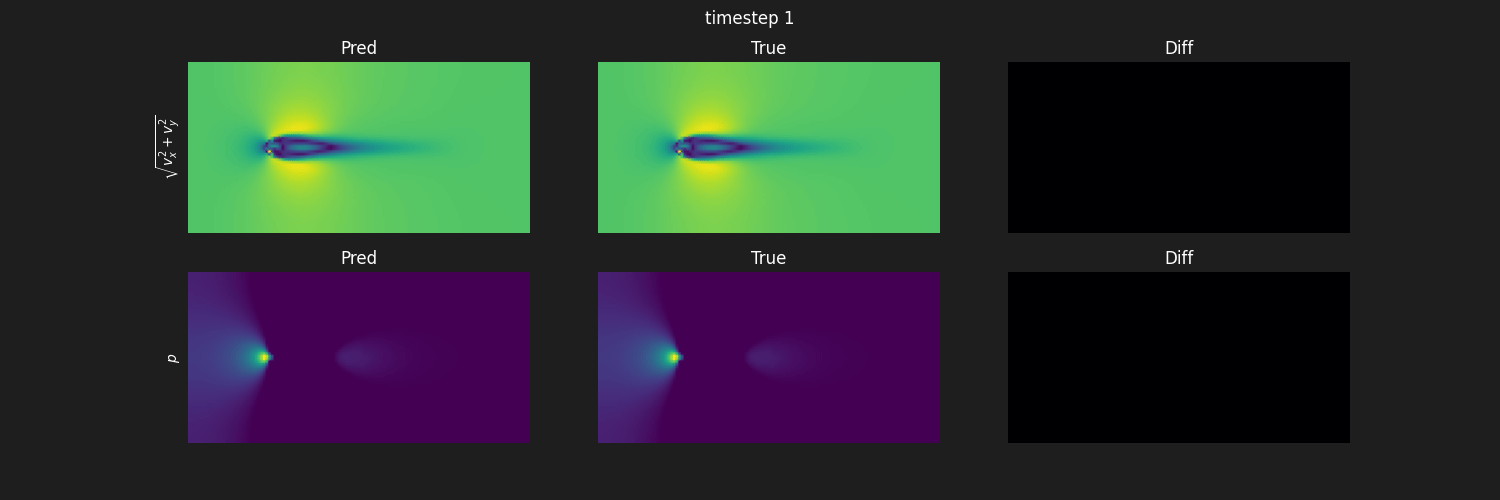

In [12]:
starting_timestep = 6
velocity, velocity_true, pressure, pressure_true = _generate_sequence(model, val_dataset, starting_timestep, length=41, trajectory_select=1)
animate_rollout(velocity, velocity_true, pressure, pressure_true, output_path="output/rollout_model1.gif")
Image(filename="output/rollout_model1.gif")

### Plot comparison
Here we visualize predicted vs true velocity and pressure fields side-by-side. Although the model predicts the next timestep quite well, the predictions deviate from the true trajectories in the long run...

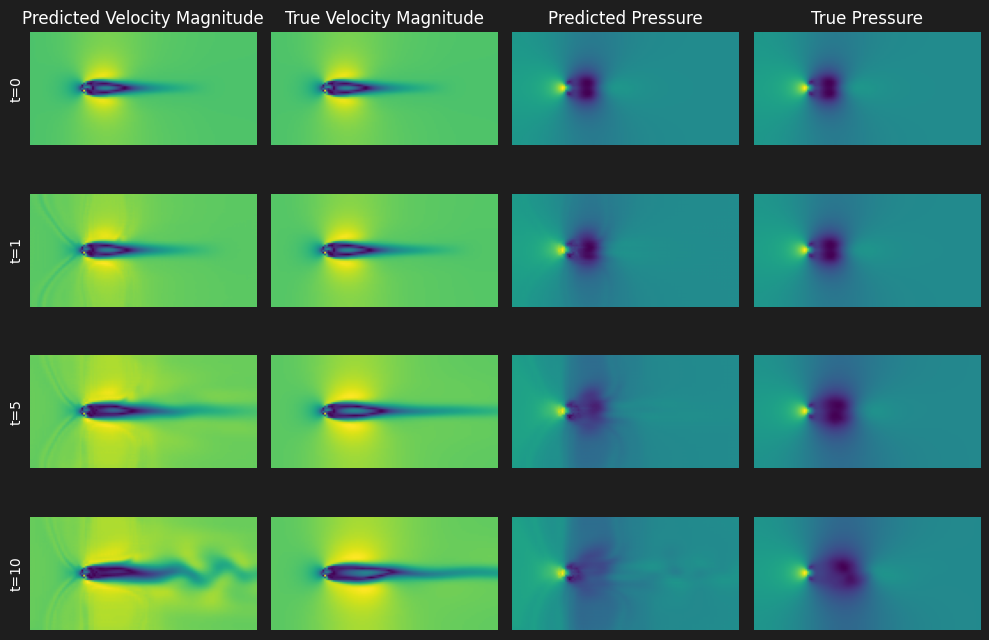

In [13]:
plot_comparison(velocity, velocity_true, pressure, pressure_true)

####

### Flow Matching

In [31]:
# =========================================================
# FLOW MATCHING (FM) CFD MODEL — CONFIG
# =========================================================
fm_device = device        # reuse your earlier 'device'
fm_sigma = 0.1            # Gaussian FM noise level
fm_epochs = 2000            # training epochs for FM
fm_lr = 1e-3              # learning rate for FM
fm_n_euler_steps = 8      # steps for Euler integration during generation


In [32]:
# =========================================================
# TIME-CONDITIONED VECTOR FIELD (UNet wrapper) + FUSE
# =========================================================
class UNet_FM(nn.Module):
    """
    Wrap SimpleUNet to accept (t, x_with_mask).
    Input:  x_with_mask -> [B, 1(mask)+3(uvp), H, W], t -> [B,1,1,1]
    Internally concatenates t-channel => total in_channels = 5
    Output: vector field in uvp space -> [B, 3, H, W]
    """
    def __init__(self, base_channels=64, mult=[1,2,2,2]):
        super().__init__()
        self.backbone = SimpleUNet(in_channels=5, out_channels=3,
                                   base_channels=base_channels, mult=mult)

    def forward(self, t, x_with_mask):
        # t: (B,1,1,1), x_with_mask: (B,4,H,W)
        B, _, H, W = x_with_mask.shape
        t_map = t.expand(B, 1, H, W)
        xt = torch.cat([x_with_mask, t_map], dim=1)  # -> (B,5,H,W)
        return self.backbone(xt)

def fm_fuse_mask(x, mask):
    """
    Concatenate static obstacle mask to the dynamic field.
    x:    (B,3,H,W)   uvp
    mask: (B,1,H,W)
    ->    (B,4,H,W)
    """
    return torch.cat([mask.to(x.device), x], dim=1)


In [33]:
# =========================================================
# GAUSSIAN FLOW MATCHING (GFM) TRAINING
# =========================================================
def GFM_CFD_training(VF, dataloader, n_epochs=50, sigma=0.1, lr=1e-3):
    optimizer = torch.optim.Adam(VF.parameters(), lr)
    loss_fn = nn.MSELoss()
    loss_hist = []

    VF.train()
    for epoch in range(n_epochs):
        running = 0.0
        for mask, coords, x_1, _ in dataloader:   # ignore coords + target
            mask = mask.to(fm_device)
            x_1  = x_1.to(fm_device)

            # Gaussian CFM path: x_t = t*x1 + N(0, (t*sigma - t + 1)^2 I)
            B = x_1.size(0)
            t = torch.rand(B,1,1,1, device=fm_device)
            eps = torch.randn_like(x_1)
            std_t = (t * sigma - t + 1).abs()
            x_t = t * x_1 + eps * std_t

            # Target velocity field: u_t(x_t|x1)
            denom = 1.0 - (1.0 - sigma) * t
            u = (x_1 - (1.0 - sigma) * x_t) / denom   # [B,3,H,W]

            # Model prediction on fused (mask + x_t)
            x_t_fused = fm_fuse_mask(x_t, mask)
            v_pred = VF(t, x_t_fused)                 # [B,3,H,W]

            loss = loss_fn(v_pred, u)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running += loss.item()

        epoch_loss = running / max(1, len(dataloader))
        loss_hist.append(epoch_loss)
        print(f"[GFM] Epoch {epoch+1}/{n_epochs} | Loss: {epoch_loss:.6f}")

    return VF, loss_hist


In [34]:
# =========================================================
# SAMPLING (Euler integration over t ∈ [0,1])
# =========================================================
@torch.no_grad()
def fm_generate(VF, mask, batch_size=16, n_steps=8, hw=(64,128)):
    VF.eval()
    H, W = hw
    x = torch.randn(batch_size, 3, H, W, device=fm_device)  # start from noise
    mask = mask.to(fm_device)                               # (B,1,H,W)

    # If mask batch has size 1, broadcast it to match batch_size
    if mask.size(0) == 1 and batch_size > 1:
        mask = mask.repeat(batch_size, 1, 1, 1)

    t_grid = torch.linspace(0, 1, n_steps + 1, device=fm_device).view(-1,1,1,1)
    for i in range(n_steps):
        dt = t_grid[i+1] - t_grid[i]
        x_fused = fm_fuse_mask(x, mask)
        v = VF(t_grid[i], x_fused)  # predicted vector field
        x = x + dt * v
    return x  # (B,3,H,W)


In [35]:
# =========================================================
# INSTANTIATE & TRAIN FM VECTOR FIELD
# =========================================================
VF = UNet_FM(base_channels=base_channels, mult=[1,2,2,2]).to(fm_device)
print(f"FM vector-field params: {_amount_params(VF)}")

VF, fm_loss_hist = GFM_CFD_training(
    VF, train_loader, n_epochs=fm_epochs, sigma=fm_sigma, lr=fm_lr
)

# Optional: save the FM vector field
# save_model(VF, '../../models/CFD/fm_gfm_vectorfield.pth')


FM vector-field params: 2015043
[GFM] Epoch 1/2000 | Loss: 0.930498
[GFM] Epoch 2/2000 | Loss: 0.487895
[GFM] Epoch 3/2000 | Loss: 0.336684
[GFM] Epoch 4/2000 | Loss: 0.265146
[GFM] Epoch 5/2000 | Loss: 0.210131
[GFM] Epoch 6/2000 | Loss: 0.173539
[GFM] Epoch 7/2000 | Loss: 0.148501
[GFM] Epoch 8/2000 | Loss: 0.132883
[GFM] Epoch 9/2000 | Loss: 0.117707
[GFM] Epoch 10/2000 | Loss: 0.109014
[GFM] Epoch 11/2000 | Loss: 0.103463
[GFM] Epoch 12/2000 | Loss: 0.100490
[GFM] Epoch 13/2000 | Loss: 0.095066
[GFM] Epoch 14/2000 | Loss: 0.091524
[GFM] Epoch 15/2000 | Loss: 0.089196
[GFM] Epoch 16/2000 | Loss: 0.086003
[GFM] Epoch 17/2000 | Loss: 0.083492
[GFM] Epoch 18/2000 | Loss: 0.080454
[GFM] Epoch 19/2000 | Loss: 0.081978
[GFM] Epoch 20/2000 | Loss: 0.078881
[GFM] Epoch 21/2000 | Loss: 0.076130
[GFM] Epoch 22/2000 | Loss: 0.074210
[GFM] Epoch 23/2000 | Loss: 0.072541
[GFM] Epoch 24/2000 | Loss: 0.071630
[GFM] Epoch 25/2000 | Loss: 0.069892
[GFM] Epoch 26/2000 | Loss: 0.067870
[GFM] Epoch 27/

Generated samples: torch.Size([16, 3, 64, 128])


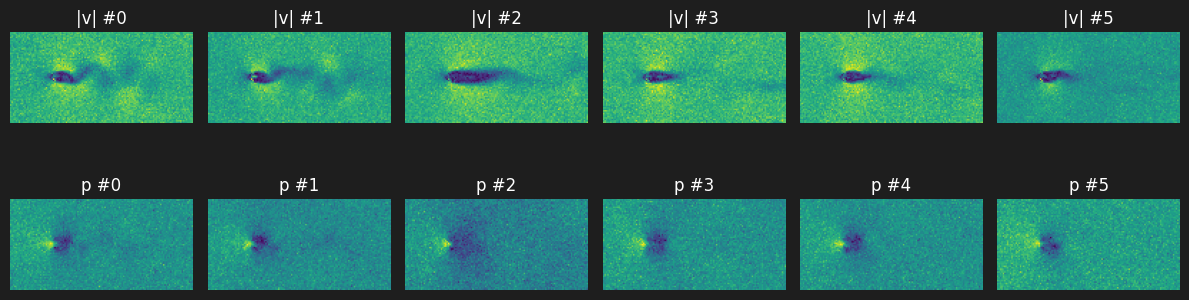

In [36]:
# =========================================================
# QUICK SAMPLE (no eval)
# =========================================================
VF.eval()
mask_batch, _, _, _ = next(iter(val_loader))
mask_batch = mask_batch.to(fm_device)

samples = fm_generate(
    VF, mask=mask_batch[:1, :1],  # take a single mask (B=1)
    batch_size=16,
    n_steps=fm_n_euler_steps, hw=(64,128)
)
print("Generated samples:", samples.shape)

# Optional mini-visualization (not an evaluation)
with torch.no_grad():
    vmag = torch.sqrt(samples[:,0]**2 + samples[:,1]**2).cpu().numpy()
    pres = samples[:,2].cpu().numpy()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 6, figsize=(12,4))
for i in range(6):
    axes[0,i].imshow(vmag[i], cmap='viridis'); axes[0,i].set_title(f'|v| #{i}'); axes[0,i].axis('off')
    axes[1,i].imshow(pres[i], cmap='viridis'); axes[1,i].set_title(f'p #{i}');   axes[1,i].axis('off')
plt.tight_layout(); plt.show()


In [37]:
# 1) basic stats (should be finite, not all zeros)
print("uvp mean/std per channel:",
      samples[:,0].mean().item(), samples[:,0].std().item(),
      samples[:,1].mean().item(), samples[:,1].std().item(),
      samples[:,2].mean().item(), samples[:,2].std().item())

print("any NaNs?", torch.isnan(samples).any().item())


uvp mean/std per channel: 1.0026235580444336 0.19999748468399048 -0.00647171214222908 0.13648070394992828 -0.0036354591138660908 0.1298595815896988
any NaNs? False


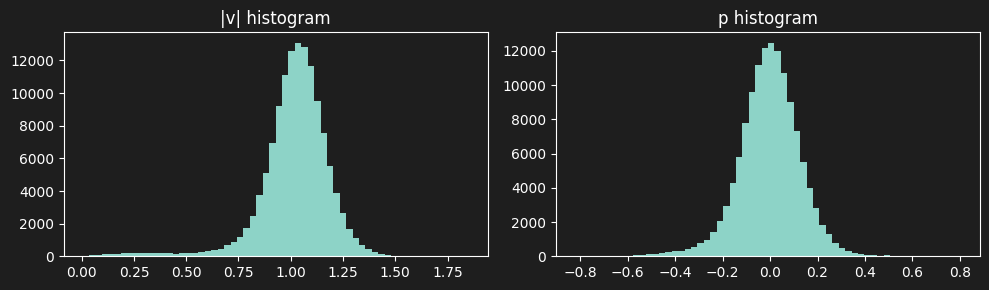

In [38]:
# 2) quick histograms (eyeball the distributions)
vmag = torch.sqrt(samples[:,0]**2 + samples[:,1]**2).flatten().cpu().numpy()
pres = samples[:,2].flatten().cpu().numpy()

plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.hist(vmag, bins=60); plt.title("|v| histogram")
plt.subplot(1,2,2); plt.hist(pres, bins=60); plt.title("p histogram")
plt.tight_layout(); plt.show()


Saved animation to: output/fm_rollout.gif


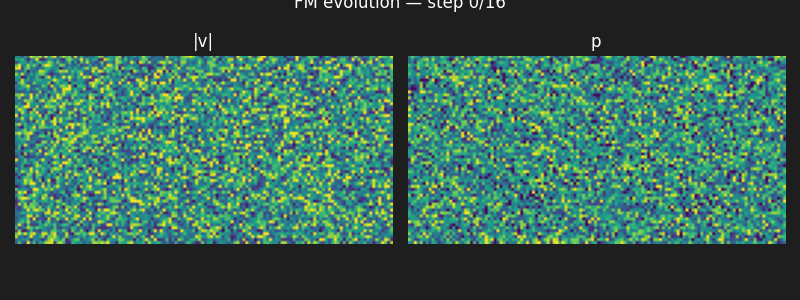

In [39]:
# =========================================================
# ANIMATE FM TRAJECTORY (|v| and p) FROM NOISE → SAMPLE
# =========================================================
import os
from matplotlib import animation

@torch.no_grad()
def fm_generate_trajectory(VF, mask, n_steps=16, hw=(64,128)):
    VF.eval()
    H, W = hw
    # single sample
    x = torch.randn(1, 3, H, W, device=fm_device)
    mask = mask.to(fm_device)
    if mask.size(0) > 1:   # use the first mask if a batch is given
        mask = mask[:1]

    frames = [x.clone()]
    t_grid = torch.linspace(0, 1, n_steps + 1, device=fm_device).view(-1,1,1,1)
    for i in range(n_steps):
        dt = t_grid[i+1] - t_grid[i]
        x_fused = torch.cat([mask, x], dim=1)     # (1,4,H,W)
        v = VF(t_grid[i], x_fused)                # (1,3,H,W)
        x = x + dt * v
        frames.append(x.clone())
    return torch.stack(frames, dim=1)  # (1, T, 3, H, W)

def animate_fm_trajectory(VF, mask, n_steps=16, hw=(64,128), outpath="output/fm_rollout.gif"):
    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    traj = fm_generate_trajectory(VF, mask, n_steps=n_steps, hw=hw)  # (1,T,3,H,W)
    T = traj.size(1)

    # compute |v| and p for each frame
    with torch.no_grad():
        vmag = torch.sqrt(traj[0,:,0]**2 + traj[0,:,1]**2).cpu().numpy()  # (T,H,W)
        pres = traj[0,:,2].cpu().numpy()

    # set consistent color scales
    vmax_v = float(np.percentile(vmag, 99))
    vmax_p = float(np.percentile(np.abs(pres), 99))

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    ax_v, ax_p = axes
    im_v = ax_v.imshow(vmag[0], cmap='viridis', vmin=0, vmax=vmax_v)
    ax_v.set_title("|v|"); ax_v.axis('off')
    im_p = ax_p.imshow(pres[0], cmap='viridis', vmin=-vmax_p, vmax=vmax_p)
    ax_p.set_title("p");   ax_p.axis('off')

    plt.tight_layout()

    def update(frame):
        im_v.set_data(vmag[frame])
        im_p.set_data(pres[frame])
        fig.suptitle(f"FM evolution — step {frame}/{T-1}", y=1.02)
        return [im_v, im_p]

    ani = animation.FuncAnimation(fig, update, frames=T, blit=False, interval=150)
    try:
        ani.save(outpath, writer="ffmpeg")
    except Exception:
        # fallback if ffmpeg not available
        ani.save(outpath, writer="pillow", fps=6)
    plt.close(fig)
    print(f"Saved animation to: {outpath}")

# ==== run it ====
mask_batch, _, _, _ = next(iter(val_loader))
animate_fm_trajectory(VF, mask_batch[:, :1], n_steps=16, hw=(64,128), outpath="output/fm_rollout.gif")

# to display in notebook (optional)
from IPython.display import Image as IPyImage
IPyImage(filename="output/fm_rollout.gif")
